# Proyecto 04 - Series de Tiempo con REDES NEURONALES

## REPOSITORIO EN GIT
https://github.com/guidosargiotto/DS-Proyecto-4



## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas_profiling import ProfileReport
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
sns.set() 

In [400]:
data_2020 = pd.read_csv(r'C:\Users\guido\Downloads\flujo-vehicular-2020.csv', sep =',')
data_2019 = pd.read_csv(r'C:\Users\guido\Downloads\flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv(r'C:\Users\guido\Downloads\flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv(r'C:\Users\guido\Downloads\flujo-vehicular-2017.csv', sep =',')

In [401]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [402]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [403]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [404]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [405]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [406]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [407]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [408]:
#Unimos los 4 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [409]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [410]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [411]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset.sample(5)

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
235103,Viernes,Provincia,Liviano,203,2019-11-22 02:00:00
237552,Miércoles,Provincia,Pesado,4,2019-12-18 00:00:00
43100,Viernes,Provincia,Liviano,564,2017-05-26 07:00:00
2422,Lunes,Centro,Liviano,328,2017-01-09 00:00:00
230210,Martes,Centro,Liviano,699,2019-10-01 21:00:00


In [412]:
dataset.tail()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00
238868,Martes,Provincia,Liviano,190,2019-12-31 23:00:00


In [413]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238869 entries, 0 to 238868
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dia             238869 non-null  object        
 1   sentido         238869 non-null  object        
 2   tipo_vehiculo   238869 non-null  object        
 3   cantidad_pasos  238869 non-null  int64         
 4   fecha           238869 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 9.1+ MB


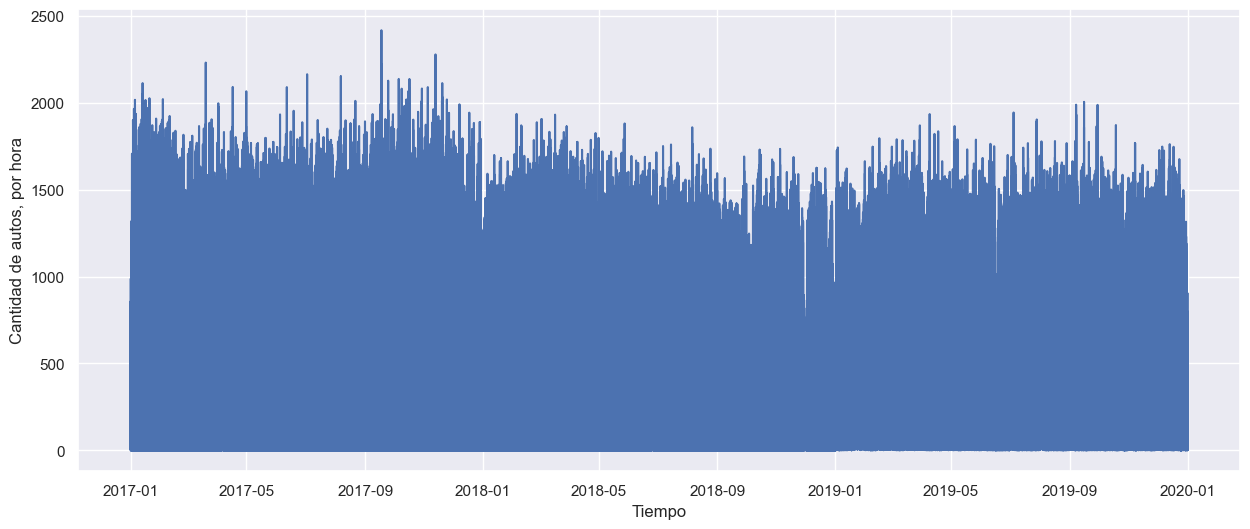

In [414]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [415]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


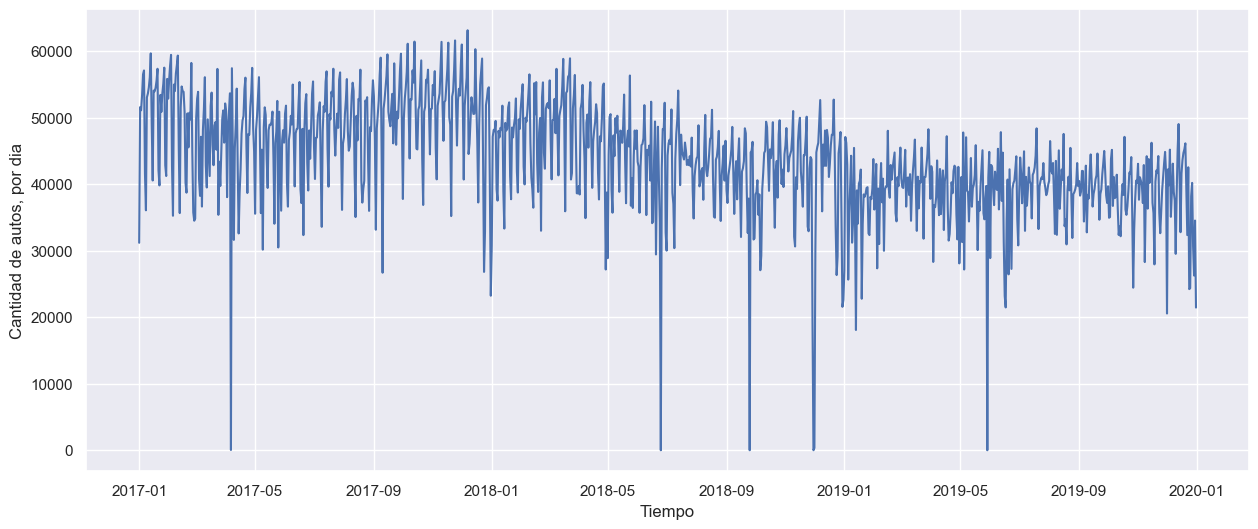

In [416]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Rápidamente se puede observar una tendencia decreciente de la cantidad de usos utilizando como metodo de pago el efectivo. A priori asumo que se explica por la migración hacia un sistema de cobro automatico asociado a una tarjeta de credito. Se observan 5 valles muy marcados, posiblemente debido a datos faltantes o 0. Los investigaremos a continuación.

# Análisis Exploratorio de Datos

Utilicemos el Profile Report para explorar nuestros datos

In [417]:
profile =  ProfileReport(diario,title = "Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Rápidamente se observa que no se observan días faltantes (1095/3 = 365) y que no hay valores nulos. Veamos a que se deben esos valores atipicos que encontramos anteriormente

# Data Cleaning (datos faltantes y tratamiento de outliers)

## Días atipicos

In [418]:
# dias atipicos
odd= diario.loc[diario.cantidad_pasos <400]
valores_a_eliminar = odd.cantidad_pasos.unique()
valores_a_eliminar
odd

,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-30,0
2018-12-01,350
2019-05-29,0


Se observan algunos días con una extraña cantidad de pasadas. Una búsqueda en la red de cada uno de ellos revela que se deben debido a manifestaciones o accidentes que impidieron la circulacion de vehiculos. Los reemplazaremos por NaN para aplicar una interpolación 

In [419]:
#Usamos interpolacion lineal para llenar los nulos
df2 = diario.replace(valores_a_eliminar,np.nan, regex=True)
df3 = df2.interpolate(method='linear', axis=0).ffill().bfill()
df3.isnull ().sum ()

cantidad_pasos    0
dtype: int64

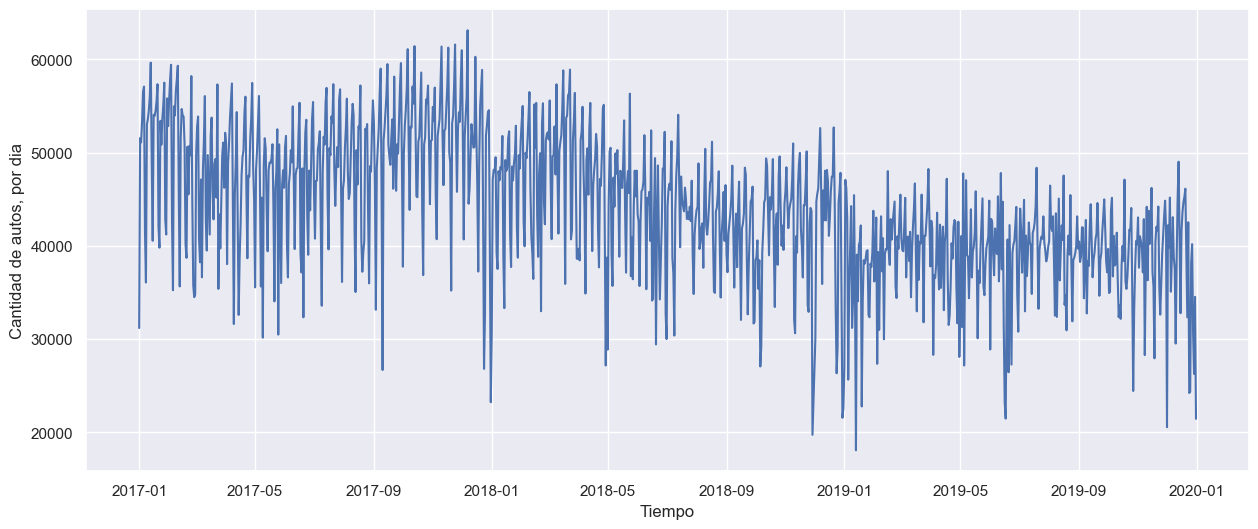

In [420]:
plt.figure(figsize = (15,6))
plt.plot(df3.index, df3.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Mucho mejor! Ya no hay quiebres abruptos en el dataset

## Detección de outliers

In [421]:
# veamos con el describe los rangos intercuartiles del dataset
df3.describe()

,cantidad_pasos
count,1095.000000
mean,43918.261644
std,7579.738335
min,18076.000000
25%,39107.500000
50%,43766.000000
75%,49514.500000
max,63127.000000


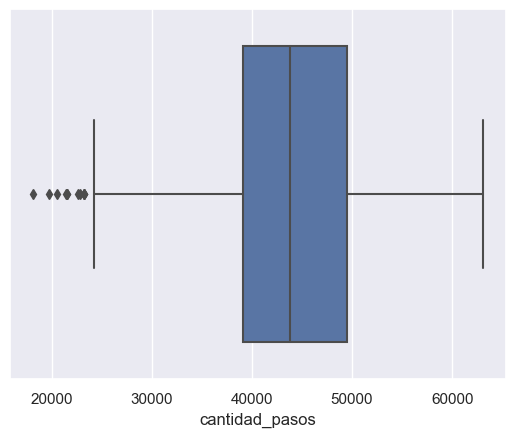

In [422]:
fig = sns.boxplot(x = df3['cantidad_pasos'])
plt.show(fig)

Se observa una distribución bastante centrada con algunos outliers importantes del  lado izquierdo, probablemente debido a choques o manifestaciones menores que interrumpieron parcialmetne el servicio. 
Utilizaremos el metodo del rango intercuartil para tratar los outliers

In [423]:
df4 = df3.copy()

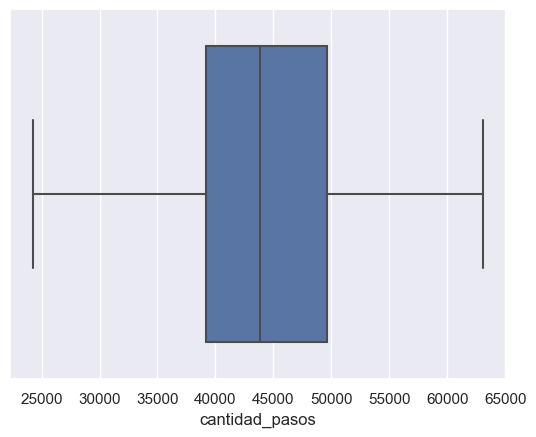

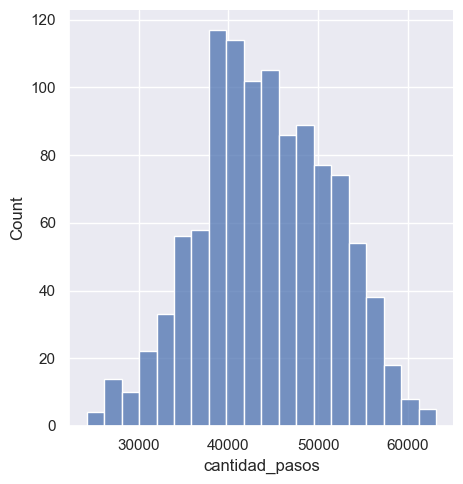

In [424]:
# tratamiento de outliers para cantidad de pasos
Q1 = df3.cantidad_pasos.quantile(0.25)
Q3 = df3.cantidad_pasos.quantile(0.75)
IQR = Q3 - Q1
df4 = df4[(df4.cantidad_pasos >= Q1 - 1.5*IQR) & (df4.cantidad_pasos <= Q3 + 1.5*IQR)]
sns.boxplot(x = df4['cantidad_pasos'])
sns.displot(df4.cantidad_pasos)
plt.show()

El tratamiento nos devolvio una distribución más normalizada

En primer lugar debemos renombrar nuestras columnas

In [425]:
df4.reset_index(inplace=True)
df4 = df4.rename(columns={'fecha': 'ds','cantidad_pasos': 'y'})
df4

,ds,y
0,2017-01-01,31183.0
1,2017-01-02,51568.0
2,2017-01-03,51093.0
3,2017-01-04,53332.0
4,2017-01-05,56486.0
...,...,...
1079,2019-12-26,38168.0
1080,2019-12-27,40182.0
1081,2019-12-28,30681.0
1082,2019-12-29,26259.0


In [426]:
#definomos nuestro train y test
end_date = '2019-01-01'
mask1 = (df4['ds'] < end_date)
mask2 = (df4['ds'] >= end_date)

df_train = df4[mask1]
df_test = df4[mask2]


Se observa el split realizado

## Predicción utilizando Redes Neuronales
        

Veamos como se comporta un modelo construido utilizando Keras con el mismo dataset y los mismos train y test splits.  Un poderoso tipo de redes neuronales diseñado para procesar sequencias son las redes neuronales recurrentes y dentro de ellas, la LSTM (long short memory), un tipo de red neuronal recurrente que se usa en deep learning.

In [427]:
#importemos las librerias que vamos a usar
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [428]:
#funcion para preparar el dataset, la funcion tiene dos argumentos, el dataset y el n° de look_back, querepresenta el numero de 'saltos' para atras que se usaran como variables de entrada para predecir el proximo valor.
def prepare_data(dataset, look_back=1):
    dX, dY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dX.append(a)
        dY.append(dataset[i + look_back, 0])
    return np.array(dX), np.array(dY)

In [429]:
ds = df4['y'].values
ds = ds.astype('float32').reshape(-1, 1)

Las LSTM son sensibles a la escala de los datos de entrada. Por eso es necesario escalar los datos de 0 a 1. Para ello utilizaremos el MinMaxScaler.

In [430]:
scaler = MinMaxScaler(feature_range=(0, 1))
ds = scaler.fit_transform(ds)

Hagamos el mismo train test split que hicimos en el trabajo 3 para poder comparar las metricas

In [431]:
tr, tst = ds[0:len(df_train),:], ds[len(df_train):len(ds),:]

In [432]:
# reshape a X=t y Y=t+1 como la funcion definida
look_back = 1
trX, trY = prepare_data(tr, look_back)
tstX, tstY = prepare_data(tst, look_back)
# reshape los inputs de modo que[samples, saltos, features]
trX = np.reshape(trX, (trX.shape[0], 1, trX.shape[1]))
tstX = np.reshape(tstX, (tstX.shape[0], 1, tstX.shape[1]))

In [433]:
# Defininimos y fitteamos el modelo, utilizando el opimizador ADAM
modelPred = Sequential()
modelPred.add(LSTM(4, input_shape=(1, look_back)))
modelPred.add(Dense(1))
modelPred.compile(loss='mean_squared_error', optimizer='adam')
modelPred.fit(trX, trY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
723/723 - 1s - loss: 0.0699 - 1s/epoch - 2ms/step
Epoch 2/100
723/723 - 0s - loss: 0.0271 - 438ms/epoch - 606us/step
Epoch 3/100
723/723 - 0s - loss: 0.0268 - 451ms/epoch - 624us/step
Epoch 4/100
723/723 - 0s - loss: 0.0265 - 435ms/epoch - 602us/step
Epoch 5/100
723/723 - 0s - loss: 0.0265 - 435ms/epoch - 602us/step
Epoch 6/100
723/723 - 0s - loss: 0.0264 - 435ms/epoch - 602us/step
Epoch 7/100
723/723 - 0s - loss: 0.0264 - 439ms/epoch - 608us/step
Epoch 8/100
723/723 - 0s - loss: 0.0264 - 435ms/epoch - 602us/step
Epoch 9/100
723/723 - 0s - loss: 0.0265 - 439ms/epoch - 608us/step
Epoch 10/100
723/723 - 0s - loss: 0.0263 - 435ms/epoch - 602us/step
Epoch 11/100
723/723 - 0s - loss: 0.0263 - 443ms/epoch - 613us/step
Epoch 12/100
723/723 - 0s - loss: 0.0263 - 437ms/epoch - 605us/step
Epoch 13/100
723/723 - 0s - loss: 0.0263 - 443ms/epoch - 613us/step
Epoch 14/100
723/723 - 0s - loss: 0.0264 - 443ms/epoch - 613us/step
Epoch 15/100
723/723 - 0s - loss: 0.0261 - 491ms/epoch - 680us

# <span style="color:red">Metricas</span>.
    
<span style="color:red">Utilizaremos dos metricas para evaluar todos nuestros modelos:
    
    
<span style="color:red">RMSE — Root Mean Squared Error
    
<span style="color:red">MAPE — Mean Absolute Percentage Error</span>.
    

<span style="color:red">El RMSE nos dira cuantas el error promedio en cantidad de pasadas que podemos esperar en cada forecast

<span style="color:red">El MAPE nos dira el porcentaje del error, muy similar al accuracy en los problemas de clasificaciòn.Por ejemplo: si obtenemos un MAPE= 0.05 nuestro modelo es 95% correcto.</span>.



In [434]:
# Hacemos las predicciones
trPredict = modelPred.predict(trX)
tstPredict = modelPred.predict(tstX)
# invertimos con el escalador
trPredict = scaler.inverse_transform(trPredict)
trY = scaler.inverse_transform([trY])
tstPredict = scaler.inverse_transform(tstPredict)
tstY = scaler.inverse_transform([tstY])
# RMSE Y MAPE
trScore = math.sqrt(mean_squared_error(trY[0], trPredict[:,0]))
print('Train Score: %.2f RMSE' % (trScore))
tstScore = math.sqrt(mean_squared_error(tstY[0], tstPredict[:,0]))
print('Test Score: %.2f RMSE' % (tstScore))

trScore = mean_absolute_percentage_error(trY[0], trPredict[:,0])
print('Train Score: %.2f MAPE' % (trScore))
tstScore = mean_absolute_percentage_error(tstY[0], tstPredict[:,0])
print('Test Score: %.2f MAPE' % (tstScore))

Train Score: 6247.17 RMSE
Test Score: 6609.81 RMSE
Train Score: 0.12 MAPE
Test Score: 0.15 MAPE


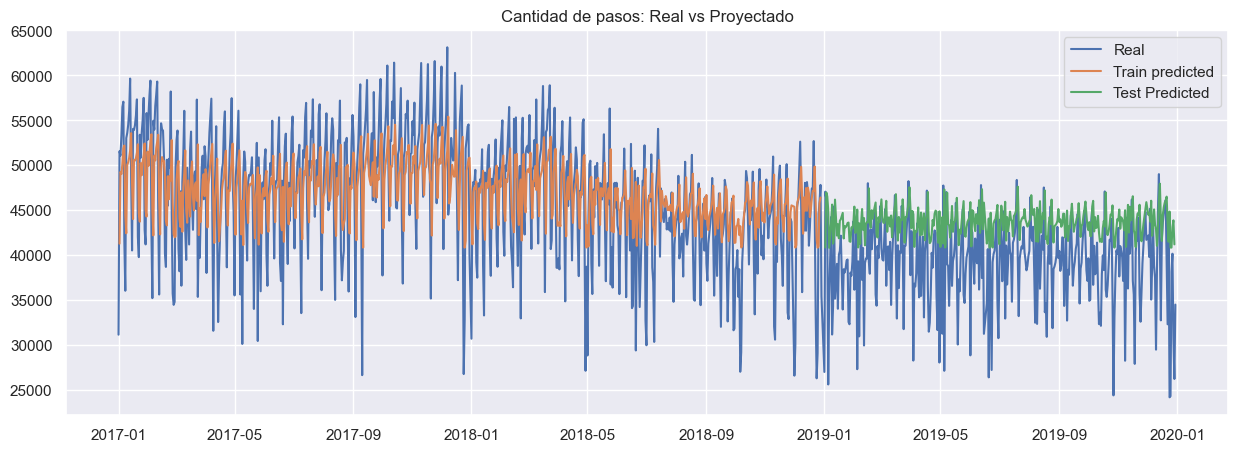

In [435]:
# Cambiamos las predicciones del train para graficar
trPredictPlot = np.empty_like(ds)
trPredictPlot[:, :] = np.nan
trPredictPlot[look_back:len(trPredict)+look_back, :] = trPredict
# Cambiamos las predicciones del test para graficar
tstPredictPlot = np.empty_like(ds)
tstPredictPlot[:, :] = np.nan
tstPredictPlot[len(trPredict)+(look_back*2)+1:len(ds)-1, :] = tstPredict
# graficamos
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(df4['ds'],scaler.inverse_transform(ds), label = 'Real')
plt.plot(df4['ds'],trPredictPlot, label = 'Train predicted')
plt.plot(df4['ds'],tstPredictPlot,label = 'Test Predicted')
plt.title('Cantidad de pasos: Real vs Proyectado')
plt.legend()
plt.show()

Se observa claramente un intento insufuciciente del modelo para explicar y predecir  los valores reales. Esta ineficiencia queda demostrada en el RMSE, superior incluso a los errores obtenidos con los modelos de Time Series utilizados en el Proyecto 3

Veamos como se comporta el  modelo para predecir el año 2020

## Predicción del año 2020

Utilizaremos el modelo creado para predecir la cantidad de pasadas del año 2020. Primero debemos hacer las mismas modificaciones que hicimos para los otros datasets.

In [436]:
data_2020 = pd.read_csv(r'C:\Users\guido\Downloads\flujo-vehicular-2020.csv', sep =',')

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020 = data_2020[mask]

#Quitamos las columnas que no vamos a utilizar
data_2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion','dia_fecha'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data_2020['fecha2'] = pd.to_datetime(data_2020.fecha) + pd.to_timedelta(data_2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_2020.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
data_2020.sort_values('fecha', inplace = True)
data_2020.reset_index(drop=True, inplace = True)

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
df_test_2020 = data_2020.resample('D', on = 'fecha').sum()
print(df_test_2020.shape)
df_test_2020.head()

df_test_2020.reset_index(inplace=True)
df_test_2020 = df_test_2020.rename(columns={'fecha': 'ds','cantidad_pasos': 'y'})
df_test_2020

(366, 1)


,ds,y
0,2020-01-01,21395.0
1,2020-01-02,33722.0
2,2020-01-03,37067.0
3,2020-01-04,30627.0
4,2020-01-05,27812.0
...,...,...
361,2020-12-27,8434.0
362,2020-12-28,10311.0
363,2020-12-29,12036.0
364,2020-12-30,12527.0


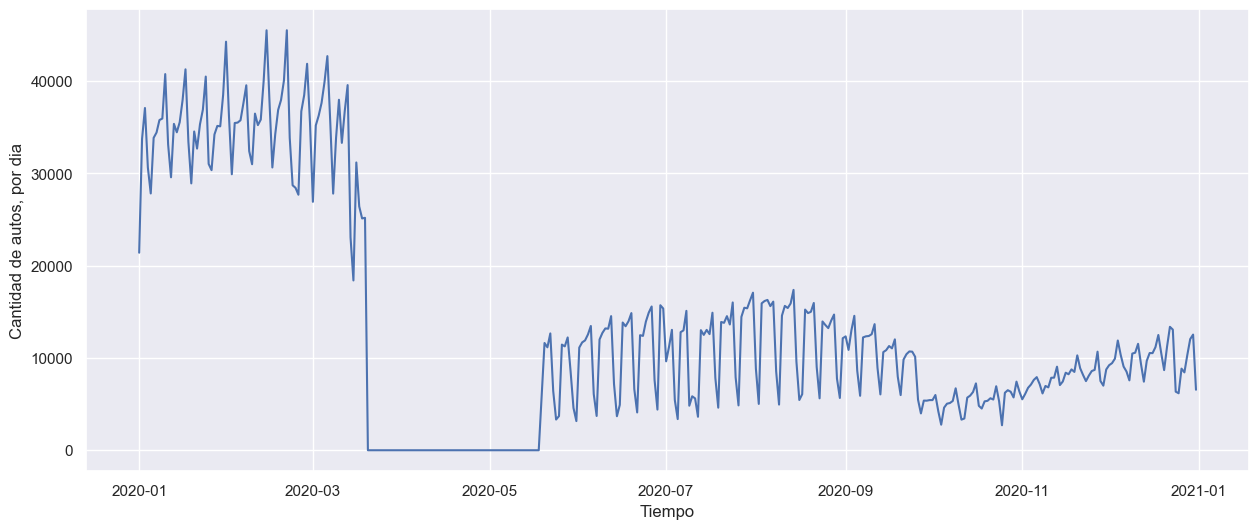

In [437]:
plt.figure(figsize = (15,6))
plt.plot(df_test_2020.ds, df_test_2020.y)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Se observa un gran vacio en los datos entre abril y mayo. Debido a la pandemia las barreras de los peajes estuvieron levantadas y no contaron las pasadas. Posteriormente se observa una lenta recuperacion del nivel de pasadas, debido a las restricciones de circulacion y la implementacion del trabajo remoto. Utilizaremos interpolacion linear para completarla pero lamentablemente va aafectar considerablemente el rendimiento del modelo

In [438]:
# dias atipicos
odd= df_test_2020.loc[df_test_2020.y <400]
valores_a_eliminar = odd.y.unique()
valores_a_eliminar

array([0., 1.])

In [439]:
df_test_2020 = df_test_2020.replace(valores_a_eliminar,np.nan, regex=True)

# Agregar las fechas faltantes

In [440]:
#Usamos interpolacion lineal para llenar los nulos
df_test_2020 = df_test_2020.interpolate(method='linear', axis=0).ffill().bfill()
df_test_2020.isnull ().sum ()

ds    0
y     0
dtype: int64

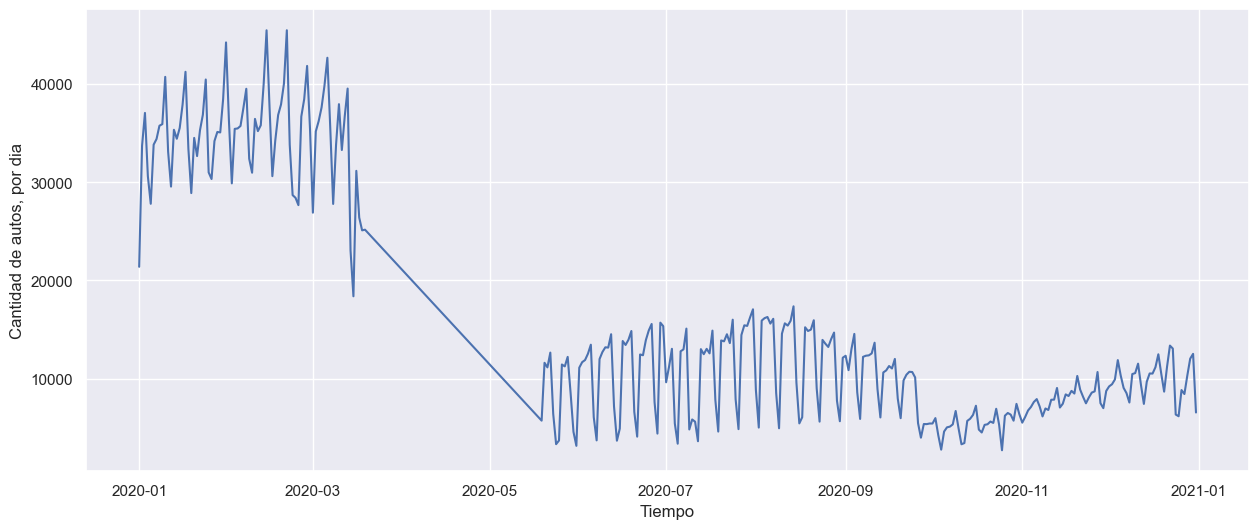

In [441]:
plt.figure(figsize = (15,6))
plt.plot(df_test_2020.ds, df_test_2020.y)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Como vemos la interpolacion no es no refleja las verdaderas fluctuaciones y por lo tanto afectara el rendimiento del modelo

In [442]:
#renombramos las columnas
df_test_2020.reset_index(inplace=True)
df_test_2020 = df_test_2020.rename(columns={'fecha': 'ds','cantidad_pasos': 'y'})
df_test_2020.drop(columns = ['index'])

,ds,y
0,2020-01-01,21395.0
1,2020-01-02,33722.0
2,2020-01-03,37067.0
3,2020-01-04,30627.0
4,2020-01-05,27812.0
...,...,...
361,2020-12-27,8434.0
362,2020-12-28,10311.0
363,2020-12-29,12036.0
364,2020-12-30,12527.0


In [443]:
# concatenamos el dataset anterior con el año 2020 
ds1 = pd.concat([df4, df_test_2020]) 

In [444]:
ds1 = ds1['y'].values
ds1 = ds1.astype('float32').reshape(-1, 1)

Las LSTM son sensibles a la escala de los datos de entrada. Por eso es necesario escalar los datos de 0 a 1. Para ello utilizaremos el MinMaxScaler.

In [447]:
#escalamos con el minmaxscaler
scaler = MinMaxScaler(feature_range=(0, 1))
ds1 = scaler.fit_transform(ds1)

In [448]:
#separamos en train y test
tr, tst = ds1[0:len(df4),:] ,ds1[len(df4):,:]
tr.shape

(1084, 1)

In [449]:
tst.shape

(366, 1)

In [450]:
# reshape a X=t y Y=t+1 como la funcion definida
look_back = 1
trX, trY = prepare_data(tr, look_back)
tstX, tstY = prepare_data(tst, look_back)
# reshape los inputs de modo que[samples, saltos, features]
trX = np.reshape(trX, (trX.shape[0], 1, trX.shape[1]))
tstX = np.reshape(tstX, (tstX.shape[0], 1, tstX.shape[1]))# reshape a X=t y Y=t+1 como la funcion definida
look_back = 1
trX, trY = prepare_data(tr, look_back)
tstX, tstY = prepare_data(tst, look_back)
# reshape los inputs de modo que[samples, saltos, features]
trX = np.reshape(trX, (trX.shape[0], 1, trX.shape[1]))
tstX = np.reshape(tstX, (tstX.shape[0], 1, tstX.shape[1]))

In [451]:
# Defininimos y fitteamos el modelo, utilizando el opimizador ADAM
modelPred = Sequential()
modelPred.add(LSTM(4, input_shape=(1, look_back)))
modelPred.add(Dense(1))
modelPred.compile(loss='mean_squared_error', optimizer='adam')
modelPred.fit(trX, trY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1082/1082 - 1s - loss: 0.0680 - 1s/epoch - 1ms/step
Epoch 2/100
1082/1082 - 1s - loss: 0.0119 - 699ms/epoch - 646us/step
Epoch 3/100
1082/1082 - 1s - loss: 0.0114 - 703ms/epoch - 650us/step
Epoch 4/100
1082/1082 - 1s - loss: 0.0112 - 688ms/epoch - 636us/step
Epoch 5/100
1082/1082 - 1s - loss: 0.0108 - 695ms/epoch - 642us/step
Epoch 6/100
1082/1082 - 1s - loss: 0.0107 - 771ms/epoch - 713us/step
Epoch 7/100
1082/1082 - 1s - loss: 0.0107 - 720ms/epoch - 666us/step
Epoch 8/100
1082/1082 - 1s - loss: 0.0106 - 735ms/epoch - 679us/step
Epoch 9/100
1082/1082 - 1s - loss: 0.0106 - 671ms/epoch - 620us/step
Epoch 10/100
1082/1082 - 1s - loss: 0.0106 - 671ms/epoch - 620us/step
Epoch 11/100
1082/1082 - 1s - loss: 0.0106 - 675ms/epoch - 624us/step
Epoch 12/100
1082/1082 - 1s - loss: 0.0106 - 677ms/epoch - 626us/step
Epoch 13/100
1082/1082 - 1s - loss: 0.0106 - 674ms/epoch - 623us/step
Epoch 14/100
1082/1082 - 1s - loss: 0.0105 - 679ms/epoch - 628us/step
Epoch 15/100
1082/1082 - 1s - loss

In [452]:
# Hacemos las predicciones
trPredict = modelPred.predict(trX)
tstPredict = modelPred.predict(tstX)
# invertimos con el escalador
trPredict = scaler.inverse_transform(trPredict)
trY = scaler.inverse_transform([trY])
tstPredict = scaler.inverse_transform(tstPredict)
tstY = scaler.inverse_transform([tstY])
# RMSE Y MAPE
trScore = math.sqrt(mean_squared_error(trY[0], trPredict[:,0]))
print('Train Score: %.2f RMSE' % (trScore))
tstScore = math.sqrt(mean_squared_error(tstY[0], tstPredict[:,0]))
print('Test Score: %.2f RMSE' % (tstScore))

trScore = mean_absolute_percentage_error(trY[0], trPredict[:,0])
print('Train Score: %.2f MAPE' % (trScore))
tstScore = mean_absolute_percentage_error(tstY[0], tstPredict[:,0])
print('Test Score: %.2f MAPE' % (tstScore))

Train Score: 0.10 RMSE
Test Score: 0.32 RMSE
Train Score: 0.13 MAPE
Test Score: 5893019612536.77 MAPE


## Conclusiones

Durante el trabajo hemos podido crear una red nueronal desde cero para trabajar sobre un ejercicio de serie de tiempo. Lamentablemente, la pandemia ha perjudicado de manera significativa la calidad de dataset y la habilidad de cualquier modelo de predecir un resultado con rangos aceptables. De todos modos, intentare aplicar el modelo en un dataset sin datos = 0 para poder observar y comparar los modelos y los resultados obtenidos.

Con respecto a los errores, estan por encima del modelo optimizado alcanzado en fbProphet por un 30%, por lo que no escogeriamos la red nueronal para este ejercicio.